In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

## Load dataset with all merged features

In [2]:
all_properties = pd.read_csv("../data/curated/houses_all_properties.csv")
all_properties.head()

,address,parking,type,num_schools,cost,suburb,beds,baths,cost/(beds+baths),geometry,...,NUMBER_OF_JOBS_PERSONS_2018-19,NUMBER_OF_JOBS_PERSONS_2019-20,NUMBER_OF_JOBS_PERSONS_2020-21,MEDIAN_INCOME_PERSONS_2016-17,MEDIAN_INCOME_PERSONS_2017-18,MEDIAN_INCOME_PERSONS_2018-19,MEDIAN_INCOME_PERSONS_2019-20,MEDIAN_INCOME_PERSONS_2020-21,centroid,distance_to_centroid
0,"(Leased) 3 Yarra Street, South Yarra VIC 3141",1,Apartment / Unit / Flat,13,460.0,South Yarra,1,1,230.00,POINT (144.992828 -37.838173),...,13060.0,12759.0,12394.0,26306.5,27750.5,29043.5,32390.5,34577.5,POINT (144.9965000772275 -37.83614617221807),0.004194
1,"004B/12 Albert Street, Hawthorn East VIC 3123",0,Apartment / Unit / Flat,14,400.0,Hawthorn East,1,1,200.00,POINT (145.048408 -37.823472),...,15422.0,14730.0,14159.0,26100.5,27117.0,26803.5,31088.0,34211.0,POINT (145.04991149745675 -37.83126983822268),0.007941
2,"04/949 Dandenong Road, Malvern East VIC 3145",0,Apartment / Unit / Flat,10,365.0,Malvern East,1,1,182.50,POINT (145.048262 -37.878631),...,18950.0,18895.0,19034.0,25636.0,26307.0,25956.5,28608.0,30642.5,POINT (145.065853863916 -37.87682309041124),0.017685
3,"0711/333 Exhibition St, Melbourne VIC 3000",0,Apartment / Unit / Flat,12,675.0,Melbourne,2,2,168.75,POINT (144.96834 -37.807831),...,13693.0,12473.0,11002.0,10656.0,10929.0,11120.5,12060.0,14478.0,POINT (144.96859287539095 -37.812787018836396),0.004962
4,"1 & 2/23 Koonawarra Street, Clayton VIC 3168",1,House,5,340.0,Clayton,1,1,170.00,POINT (145.124589 -37.90863),...,6188.0,6445.0,7536.0,11981.0,12020.0,11625.0,12689.5,12635.0,POINT (145.1381453634467 -37.91053619756948),0.013690


## Process the dataset for prediction

#### Filtering suburbs with less than 50 properties

In [3]:
stratify_column = 'SA2_Name'

house_counts = all_properties[stratify_column].value_counts()

all_properties = all_properties[all_properties[stratify_column].isin(house_counts[house_counts >= 50].index)]

#### Convert categorical attributes to numerical 

In [4]:
mapping = {category: index for index, category in enumerate(all_properties['SA2_Name'].unique())}

all_properties['map_SA2_Name'] = all_properties['SA2_Name'].map(mapping)
all_properties['type'] = all_properties['type'].apply(lambda x: 0 if x == 'House' else 1) 

#### Filter for needed columns

In [5]:
columns = ['SA2_Name', 'parking', 'type', 'num_schools', 'cost', 'beds', 'baths',
            'closest_train_station_distance_km', 'closest_tram_station_distance_km', 'closest_hospital_distance_km',
            'closest_grocery_distance_km', 'Net_migration_2021_22', 'Net_migration_2022_23', 'ERP_per_km2_2021',
            'ERP_per_km2_2022', 'ERP_per_km2_2023', 'ERP_increase_2020_21', 'ERP_increase_2021_22', 'ERP_increase_2022_23',
            'NUMBER_OF_JOBS_PERSONS_2020-21', 'MEDIAN_INCOME_PERSONS_2020-21', 'map_SA2_Name']

all_properties = all_properties[columns]

all_properties.dtypes

SA2_Name                              object
parking                                int64
type                                   int64
num_schools                            int64
cost                                 float64
beds                                   int64
baths                                  int64
closest_train_station_distance_km    float64
closest_tram_station_distance_km     float64
closest_hospital_distance_km         float64
closest_grocery_distance_km          float64
Net_migration_2021_22                  int64
Net_migration_2022_23                  int64
ERP_per_km2_2021                     float64
ERP_per_km2_2022                     float64
ERP_per_km2_2023                     float64
ERP_increase_2020_21                   int64
ERP_increase_2021_22                   int64
ERP_increase_2022_23                   int64
NUMBER_OF_JOBS_PERSONS_2020-21       float64
MEDIAN_INCOME_PERSONS_2020-21        float64
map_SA2_Name                           int64
dtype: obj

#### Normalize data

In [6]:
exclude_columns = ['parking', 'type', 'num_schools', 'beds', 'baths', 'map_SA2_Name', 'cost']
columns_to_scale = [col for col in all_properties.columns if all_properties[col].dtype != object and col not in exclude_columns]

scaler = MinMaxScaler()

data_scaled = all_properties.copy()
data_scaled[columns_to_scale] = scaler.fit_transform(data_scaled[columns_to_scale])

In [7]:
display(data_scaled.describe())

,parking,type,num_schools,cost,beds,baths,closest_train_station_distance_km,closest_tram_station_distance_km,closest_hospital_distance_km,closest_grocery_distance_km,...,Net_migration_2022_23,ERP_per_km2_2021,ERP_per_km2_2022,ERP_per_km2_2023,ERP_increase_2020_21,ERP_increase_2021_22,ERP_increase_2022_23,NUMBER_OF_JOBS_PERSONS_2020-21,MEDIAN_INCOME_PERSONS_2020-21,map_SA2_Name
count,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,...,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000
mean,1.017833,0.640858,8.681264,642.020377,2.358239,1.498871,0.062190,0.068235,0.087257,0.068030,...,0.381078,0.251987,0.244295,0.237608,0.368165,0.236066,0.356507,0.560901,0.542452,24.918962
std,0.890175,0.479803,3.587438,260.052483,1.101988,0.564530,0.136905,0.141491,0.152086,0.147144,...,0.251873,0.270263,0.268934,0.268134,0.192559,0.203636,0.229078,0.266489,0.282809,14.836719
min,0.000000,0.000000,0.000000,165.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,7.000000,500.000000,2.000000,1.000000,0.010226,0.000433,0.019542,0.010065,...,0.193342,0.032911,0.030243,0.026538,0.268263,0.102794,0.185663,0.368309,0.346444,12.000000
50%,1.000000,1.000000,10.000000,580.000000,2.000000,1.000000,0.021734,0.000979,0.043614,0.021595,...,0.325433,0.202033,0.186103,0.171406,0.333818,0.183129,0.306422,0.609111,0.563565,24.000000
75%,2.000000,1.000000,11.000000,700.000000,3.000000,2.000000,0.042771,0.080316,0.080021,0.053400,...,0.496671,0.302712,0.294525,0.305220,0.430473,0.303451,0.441655,0.802165,0.732110,39.000000
max,11.000000,1.000000,15.000000,3800.000000,9.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,46.000000


## Rental price prediction models

#### Linear Regression with features' coefficients

In [8]:
X = data_scaled.drop(columns=["cost", "SA2_Name"])
y = data_scaled["cost"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=data_scaled['map_SA2_Name']
)

In [9]:
linear_model = LinearRegression()

linear_model.fit(X_train, y_train)

y_pred_linear_test = linear_model.predict(X_test)
y_pred_linear_train = linear_model.predict(X_train)

rmse_linear_test = root_mean_squared_error(y_test, y_pred_linear_test)
rmse_linear_train = root_mean_squared_error(y_train, y_pred_linear_train)

mae_linear_test = mean_absolute_error(y_test, y_pred_linear_test)
mae_linear_train = mean_absolute_error(y_train, y_pred_linear_train)

r2_linear_test = r2_score(y_test, y_pred_linear_test) 
r2_linear_train = r2_score(y_train, y_pred_linear_train) 

print(f'Root Mean Squared Error: Test: {rmse_linear_test} and Train: {rmse_linear_train}')
print(f'Mean Absolute Error: Test: {mae_linear_test} and Train: {mae_linear_train}')
print(f'R² Score: Test: {r2_linear_test} and Train: {r2_linear_train}')

Root Mean Squared Error: Test: 185.11823640399786 and Train: 173.21185184463573
Mean Absolute Error: Test: 118.9561671688757 and Train: 112.64236772152324
R² Score: Test: 0.5366971404787877 and Train: 0.545544364332986


In [10]:
coefficients = linear_model.coef_

feature_names = X_train.columns if hasattr(X_train, 'columns') else range(X_train.shape[1])
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the DataFrame by coefficients
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)

print(coefficients_df)

                              Feature   Coefficient
11                   ERP_per_km2_2021  12830.099725
10              Net_migration_2022_23   5915.378114
15               ERP_increase_2021_22   4281.222798
13                   ERP_per_km2_2023   3501.425697
5   closest_train_station_distance_km    559.561881
4                               baths    183.811419
3                                beds    122.429486
17     NUMBER_OF_JOBS_PERSONS_2020-21    120.585313
18      MEDIAN_INCOME_PERSONS_2020-21     62.514209
2                         num_schools     30.351208
0                             parking     22.038688
8         closest_grocery_distance_km     13.573022
1                                type      9.200824
14               ERP_increase_2020_21      7.869836
19                       map_SA2_Name      1.981493
7        closest_hospital_distance_km   -290.753958
6    closest_tram_station_distance_km   -372.865076
9               Net_migration_2021_22  -3061.878332
16          

#### Random Forest Regression with features' importances

In [11]:
rf_model = RandomForestRegressor(max_depth = 5)

rf_model.fit(X_train, y_train)

y_pred_rf_test = rf_model.predict(X_test)
y_pred_rf_train = rf_model.predict(X_train)

rmse_rf_test = root_mean_squared_error(y_test, y_pred_rf_test) 
rmse_rf_train = root_mean_squared_error(y_train, y_pred_rf_train)

mae_rf_test = mean_absolute_error(y_test, y_pred_rf_test)
mae_rf_train = mean_absolute_error(y_train, y_pred_rf_train)

r2_rf_test = r2_score(y_test, y_pred_rf_test)
r2_rf_train = r2_score(y_train, y_pred_rf_train)

print(f'Root Mean Squared Error: Test: {rmse_rf_test} and Train: {rmse_rf_train}')
print(f'Mean Absolute Error: Test: {mae_rf_test} and Train: {mae_rf_train}')
print(f'R² Score: Test: {r2_rf_test} and Train: {r2_rf_train}')

Root Mean Squared Error: Test: 150.7623422009944 and Train: 130.43947355257905
Mean Absolute Error: Test: 89.1302048946549 and Train: 82.64526546573454
R² Score: Test: 0.6927072428049638 and Train: 0.7422762995416939


In [12]:
importance = rf_model.feature_importances_

feature_names = X_train.columns if hasattr(X_train, 'columns') else range(X_train.shape[1])
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

                              Feature  Importance
6    closest_tram_station_distance_km    0.314431
3                                beds    0.279152
4                               baths    0.233514
0                             parking    0.048487
5   closest_train_station_distance_km    0.032558
8         closest_grocery_distance_km    0.013573
13                   ERP_per_km2_2023    0.013270
7        closest_hospital_distance_km    0.010364
12                   ERP_per_km2_2022    0.009971
2                         num_schools    0.008875
19                       map_SA2_Name    0.008445
17     NUMBER_OF_JOBS_PERSONS_2020-21    0.006407
11                   ERP_per_km2_2021    0.005791
14               ERP_increase_2020_21    0.003526
16               ERP_increase_2022_23    0.002810
10              Net_migration_2022_23    0.002319
9               Net_migration_2021_22    0.002306
15               ERP_increase_2021_22    0.001908
18      MEDIAN_INCOME_PERSONS_2020-21    0.001850


## Aggregate predictions 

In [13]:
y_pred_series = pd.Series(rf_model.predict(X), name='predicted_cost').reset_index(drop=True)
X_reset = X.reset_index(drop=True)
predicted = pd.concat([X_reset, y_pred_series], axis=1)
predicted = pd.concat([predicted, data_scaled["SA2_Name"].reset_index(drop=True)], axis = 1)

In [14]:
predicted["predicted_cost/(beds+baths)"] = predicted["predicted_cost"] / (predicted["beds"] + predicted["baths"])
predicted

,parking,type,num_schools,beds,baths,closest_train_station_distance_km,closest_tram_station_distance_km,closest_hospital_distance_km,closest_grocery_distance_km,Net_migration_2021_22,...,ERP_per_km2_2023,ERP_increase_2020_21,ERP_increase_2021_22,ERP_increase_2022_23,NUMBER_OF_JOBS_PERSONS_2020-21,MEDIAN_INCOME_PERSONS_2020-21,map_SA2_Name,predicted_cost,SA2_Name,predicted_cost/(beds+baths)
0,1,1,13,1,1,0.000809,0.000429,0.055319,0.002738,0.152916,...,0.287190,0.338628,0.139858,0.285617,0.428344,0.872090,0,509.993345,South Yarra - North,254.996673
1,0,1,14,1,1,0.006237,0.003125,0.069408,0.039815,0.129314,...,0.113851,0.333818,0.118861,0.200362,0.545557,0.858458,1,404.678246,Hawthorn East,202.339123
2,0,1,10,1,1,0.013296,0.001173,0.053401,0.048763,0.132090,...,0.078602,0.327106,0.115026,0.197874,0.869305,0.725731,2,425.045550,Malvern East,212.522775
3,0,1,12,2,2,0.013744,0.000145,0.011402,0.013936,0.197342,...,0.402156,0.176082,0.179843,0.417006,0.335901,0.124507,3,792.332382,Melbourne CBD - East,198.083096
4,4,0,1,3,1,0.859816,0.229993,0.528168,0.321530,0.083102,...,0.006514,0.464481,0.065182,0.029398,0.490636,0.563565,4,516.321946,Point Nepean,129.080487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4425,2,1,11,2,2,0.029150,0.000198,0.030752,0.054063,0.050377,...,0.179809,0.292538,0.063721,0.198100,0.802165,0.643439,31,793.071623,St Kilda East,198.267906
4426,0,1,11,1,1,0.010041,0.000826,0.012066,0.006076,0.197342,...,0.402156,0.176082,0.179843,0.417006,0.335901,0.124507,3,515.932986,Melbourne CBD - East,257.966493
4427,0,1,9,1,1,0.015020,0.000491,0.017971,0.013197,0.324078,...,0.518286,0.123392,0.303451,0.634781,0.901913,0.083594,42,538.978999,Melbourne CBD - West,269.489499
4428,1,1,8,2,2,0.013746,0.001090,0.009566,0.009696,0.221142,...,0.103530,0.349927,0.205404,0.441655,0.819564,0.472867,5,737.329756,Footscray,184.332439


#### Livable and affordable indexes

In [15]:
proximity_columns = [col for col in data_scaled.columns if "distance" in col]
proximity_weights = data_scaled.drop(["SA2_Name"], axis=1).corr()["cost"][proximity_columns]

In [16]:
all_properties['total_weighted_proximity_individual'] = (
    all_properties['closest_train_station_distance_km'] * proximity_weights['closest_train_station_distance_km'] +
    all_properties['closest_tram_station_distance_km'] * proximity_weights['closest_tram_station_distance_km'] +
    all_properties['closest_hospital_distance_km'] * proximity_weights['closest_hospital_distance_km'] +
    all_properties['closest_grocery_distance_km'] * proximity_weights['closest_grocery_distance_km']
)

aggregated_proximity = all_properties.groupby("SA2_Name")['total_weighted_proximity_individual'].mean().reset_index(name = "livability")
aggregated_proximity['livability'] = scaler.fit_transform(aggregated_proximity[['livability']])

In [17]:
affordability = predicted.groupby("SA2_Name")['predicted_cost/(beds+baths)'].mean().reset_index(name = "affordability")
affordability["affordability"] = scaler.fit_transform(affordability[["affordability"]])
affordability["affordability"] = 1 - affordability["affordability"]


In [18]:
aggregated_proximity = pd.concat([aggregated_proximity, affordability["affordability"]], axis=1)
aggregated_proximity["total_score"] = aggregated_proximity['livability'] + aggregated_proximity['affordability']
aggregated_proximity = aggregated_proximity.sort_values(by = "total_score", ascending = False).reset_index(drop = True)
aggregated_proximity.to_csv("../data/curated/suburb_ranking.csv")

#### Predicted median rental price for 9/2024

In [19]:
aggregated_df = predicted.groupby("SA2_Name")['predicted_cost'].median().reset_index(name='SA2_Median')
aggregated_df

,SA2_Name,SA2_Median
0,Albert Park,603.189268
1,Alfredton,537.706753
2,Barwon Heads - Armstrong Creek,537.706753
3,Bendigo,494.974068
4,Carlton,639.870398
5,Carnegie,599.920183
6,Caulfield - North,599.920183
7,Clyde North - South,572.153439
8,Docklands,639.870398
9,Doncaster,575.434120


In [20]:
aggregated_subs = aggregated_df["SA2_Name"].unique()

In [21]:
len(aggregated_subs)

47

#### Combine with historical rental data

In [22]:
subs_w_hist = pd.read_csv("../data/curated/suburb_w_hist.csv")
subs_w_hist['Suburb'] = subs_w_hist['Suburb'].replace('Melbourne', 'CBD')

In [23]:
subs_w_hist[subs_w_hist["Suburb"] == "Abbotsford"].sort_values(by='date')

,Suburb,date,median_rental_price
87,Abbotsford,2000-03-01,230
8,Abbotsford,2000-06-01,235
48,Abbotsford,2000-09-01,240
18,Abbotsford,2000-12-01,245
74,Abbotsford,2001-03-01,250
...,...,...,...
1,Abbotsford,2023-09-01,550
37,Abbotsford,2023-12-01,580
85,Abbotsford,2024-03-01,600
12,Abbotsford,2024-06-01,610


In [24]:
contain = []

for suburb in subs_w_hist["Suburb"].unique():
    for sub in aggregated_subs:
        if suburb == sub:
            contain.append((suburb, sub))
            break
        elif suburb in sub:
            contain.append((suburb, sub))
    
compare_suburbs = pd.DataFrame(contain, columns = ["sub_w_hist", "sa2"])

In [25]:
len(compare_suburbs["sa2"].unique())

37

In [26]:
count = Counter(compare_suburbs["sa2"])

duplicates = []

for item in count:
    if count[item] > 1:
        print(item, count[item])
        duplicates.append(item)

Malvern - Glen Iris 2
Hawthorn East 2
Malvern East 2
Prahran - Windsor 2
St Kilda East 2


## Predict rental price for 2025, 2026 and 2027

In [60]:
results_linear = []

for suburb in compare_suburbs["sa2"]:
    
    if suburb in duplicates:
        if "-" in suburb:
            hist_subs = list(compare_suburbs[compare_suburbs["sa2"] == suburb]["sub_w_hist"])
            hist_data = pd.concat([subs_w_hist[subs_w_hist["Suburb"] == hist_subs[0]][['date', 'median_rental_price']], 
                                   subs_w_hist[subs_w_hist["Suburb"] == hist_subs[1]][['date', 'median_rental_price']]])
        else:
            hist_subs = list(compare_suburbs[compare_suburbs["sa2"] == suburb]["sub_w_hist"])
            if hist_subs[0] == suburb:
                hist_data = subs_w_hist[subs_w_hist["Suburb"] == hist_subs[0]][['date', 'median_rental_price']]
            else:
                hist_data = subs_w_hist[subs_w_hist["Suburb"] == hist_subs[1]][['date', 'median_rental_price']]
                
    else:
        hist_sub = list(compare_suburbs[compare_suburbs["sa2"] == suburb]["sub_w_hist"])[0]
        hist_data = subs_w_hist[subs_w_hist["Suburb"] == hist_sub][['date', 'median_rental_price']]
        
    suburb_df = hist_data.copy()
    suburb_df['date'] = pd.to_datetime(suburb_df['date'])
    
    suburb_df['median_rental_price'] = pd.to_numeric(suburb_df['median_rental_price'], errors='coerce')
    
    true_df = suburb_df[suburb_df['date'].dt.year == 2024]
    
    suburb_df = suburb_df[suburb_df['date'] >= '2021-01-01']
    suburb_df = suburb_df[suburb_df['date'] <= '2023-12-31']

    suburb_df['year'] = suburb_df['date'].dt.year

    X_historical = suburb_df[['year']] 
    y_historical = suburb_df['median_rental_price'] 

    future_model = LinearRegression()
    future_model.fit(X_historical, y_historical)
    
    # Forecast for the years 2024, 2025, 2026, and 2027
    forecast_years = pd.DataFrame({'year': [2024, 2025, 2026, 2027]})
    forecasted_prices = future_model.predict(forecast_years)
    
    growth_2025 = (forecasted_prices[1] - forecasted_prices[0]) / forecasted_prices[0] * 100
    growth_2026 = (forecasted_prices[2] - forecasted_prices[1]) / forecasted_prices[0] * 100
    growth_2027 = (forecasted_prices[3] - forecasted_prices[2]) / forecasted_prices[1] * 100
    average_growth = (growth_2025 + growth_2026 + growth_2027) / 3
    
    result_row = {
        'Suburb': suburb,
        'true_2024': true_df['median_rental_price'].mean(),
        'forecasted_2024': forecasted_prices[0],
        'forecasted_2025': forecasted_prices[1],
        'forecasted_2026': forecasted_prices[2],
        'forecasted_2027': forecasted_prices[3],
        'growth_2025_%': growth_2025,
        'growth_2026_%': growth_2026,
        'growth_2027_%': growth_2027,
        'average_growth_%': average_growth
    }
    
    results_linear.append(result_row)

final_df_linear = pd.DataFrame(results_linear)

final_df_linear = final_df_linear[['Suburb', 'true_2024', 'forecasted_2024', 'forecasted_2025', 'forecasted_2026', 'forecasted_2027', 
                        'growth_2025_%', 'growth_2026_%', 'growth_2027_%', 'average_growth_%']]
final_df_linear = final_df_linear.drop_duplicates()
final_df_linear = final_df_linear.sort_values(by = 'average_growth_%', ascending = False).reset_index(drop = True)

final_df_linear

,Suburb,true_2024,forecasted_2024,forecasted_2025,forecasted_2026,forecasted_2027,growth_2025_%,growth_2026_%,growth_2027_%,average_growth_%
0,Melbourne CBD - North,648.333333,681.250000,791.875000,902.500000,1013.125000,16.238532,16.238532,13.970008,15.482357
1,Melbourne CBD - East,648.333333,681.250000,791.875000,902.500000,1013.125000,16.238532,16.238532,13.970008,15.482357
2,Melbourne CBD - West,648.333333,681.250000,791.875000,902.500000,1013.125000,16.238532,16.238532,13.970008,15.482357
3,Southbank (West) - South Wharf,651.000000,686.250000,786.250000,886.250000,986.250000,14.571949,14.571949,12.718601,13.954166
4,Southbank - East,651.000000,686.250000,786.250000,886.250000,986.250000,14.571949,14.571949,12.718601,13.954166
5,Docklands,650.000000,677.500000,772.500000,867.500000,962.500000,14.022140,14.022140,12.297735,13.447338
6,Carlton,578.333333,594.583333,670.833333,747.083333,823.333333,12.824107,12.824107,11.366460,12.338224
7,North Melbourne,580.000000,584.583333,656.458333,728.333333,800.208333,12.295082,12.295082,10.948905,11.846356
8,West Melbourne - Residential,580.000000,584.583333,656.458333,728.333333,800.208333,12.295082,12.295082,10.948905,11.846356
9,Caulfield - North,616.666667,591.666667,657.291667,722.916667,788.541667,11.091549,11.091549,9.984152,10.722417


In [52]:
results_arima = []
validation_arima = []

# Loop through each suburb in the dataset
for suburb in compare_suburbs["sa2"]:
    
    if suburb in duplicates:
        if "-" in suburb:
            hist_subs = list(compare_suburbs[compare_suburbs["sa2"] == suburb]["sub_w_hist"])
            hist_data = pd.concat([subs_w_hist[subs_w_hist["Suburb"] == hist_subs[0]][['date', 'median_rental_price']], 
                                   subs_w_hist[subs_w_hist["Suburb"] == hist_subs[1]][['date', 'median_rental_price']]])
        else:
            hist_subs = list(compare_suburbs[compare_suburbs["sa2"] == suburb]["sub_w_hist"])
            if hist_subs[0] == suburb:
                hist_data = subs_w_hist[subs_w_hist["Suburb"] == hist_subs[0]][['date', 'median_rental_price']]
            else:
                hist_data = subs_w_hist[subs_w_hist["Suburb"] == hist_subs[1]][['date', 'median_rental_price']]
    else:
        hist_sub = list(compare_suburbs[compare_suburbs["sa2"] == suburb]["sub_w_hist"])[0]
        hist_data = subs_w_hist[subs_w_hist["Suburb"] == hist_sub][['date', 'median_rental_price']]
    
    suburb_df = hist_data.copy()
    suburb_df['date'] = pd.to_datetime(suburb_df['date'])
    suburb_df['median_rental_price'] = pd.to_numeric(suburb_df['median_rental_price'], errors='coerce')
    suburb_df = suburb_df.drop_duplicates(subset='date', keep='first')
    suburb_df = suburb_df.sort_values('date').set_index('date')

    # Train auto ARIMA model 
    try:
        arima_model = auto_arima(
            suburb_df['median_rental_price'],
            start_p=0, max_p=5,
            start_q=0, max_q=5,
            d=None,
            seasonal=True,
            m=4,  # Quarterly data
            start_P=0, max_P=2,
            start_Q=0, max_Q=2,
            D=None,
            trace=False,
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True
        )
    except:
        # Skip suburb if ARIMA fails
        continue

    # Forecast for the next 14 quarters
    forecast_steps = 14
    forecast = arima_model.predict(n_periods=forecast_steps)
    forecast_dates = pd.date_range(start=suburb_df.index[-1] + pd.offsets.QuarterEnd(), periods=forecast_steps, freq='QE')

    # Create a DataFrame for forecasted values
    forecast_df = pd.DataFrame({'date': forecast_dates, 'forecasted_price': forecast})
    forecast_df['year_quarter'] = forecast_df['date'].dt.to_period('Q')

    # Pivot the DataFrame to structure it as required
    forecast_pivot = forecast_df.pivot_table(index=None, columns='year_quarter', values='forecasted_price')
    forecast_pivot.insert(0, 'Suburb', suburb)

    # Append to results_arima
    results_arima.append(forecast_pivot)
    validation_arima.append(pd.DataFrame({'median_rental_price': suburb_df[suburb_df.index == "2024-09-01"]["median_rental_price"],
                                    'suburb': suburb}))
    
# Combine results_arima into a single DataFrame
final_arima_df = pd.concat(results_arima, ignore_index=True).drop_duplicates(subset="Suburb")
validation_arima_df = pd.concat(validation_arima).drop_duplicates(subset="suburb")

# Rename columns for clarity and sort as needed
final_arima_df.columns = ['Suburb'] + [str(col) for col in final_arima_df.columns[1:]]
final_arima_df = final_arima_df.rename(columns=lambda x: str(x).replace(' ', '_'))

# Display final DataFrame
print(final_arima_df.head())
print("\n\n")
print(validation_arima_df.head())

                           Suburb      2024Q3      2024Q4      2025Q1  \
0                     Albert Park  700.662265  695.039904  696.425748   
1                       Alfredton  434.425341  437.690591  440.192007   
2  Barwon Heads - Armstrong Creek  566.335439  571.318948  575.803703   
3                         Bendigo  444.109610  452.206660  462.426400   
4                         Carlton  587.396838  578.398643  571.548949   

       2025Q2      2025Q3      2025Q4      2026Q1      2026Q2      2026Q3  \
0  692.390812  693.550746  689.191736  690.222575  689.181547  691.177032   
1  443.062383  446.340281  449.531904  452.526978  455.523112  458.606386   
2  580.104459  584.337333  588.545165  592.743757  596.938942  601.132869   
3  468.400758  477.748155  486.249142  494.299547  503.251116  511.486692   
4  565.443863  563.737087  554.442604  548.714545  545.059623  543.875563   

       2026Q4      2027Q1      2027Q2      2027Q3      2027Q4  
0  691.210831  693.663681  695.411

In [54]:
rmse = root_mean_squared_error(final_arima_df["2024Q3"], validation_arima_df["median_rental_price"])
mae = mean_absolute_error(final_arima_df["2024Q3"], validation_arima_df["median_rental_price"])
r2 = r2_score(final_arima_df["2024Q3"], validation_arima_df["median_rental_price"])

print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

Root Mean Squared Error: 10.190545229686824
Mean Absolute Error: 9.210836292944252
R² Score: 0.9802517461969021


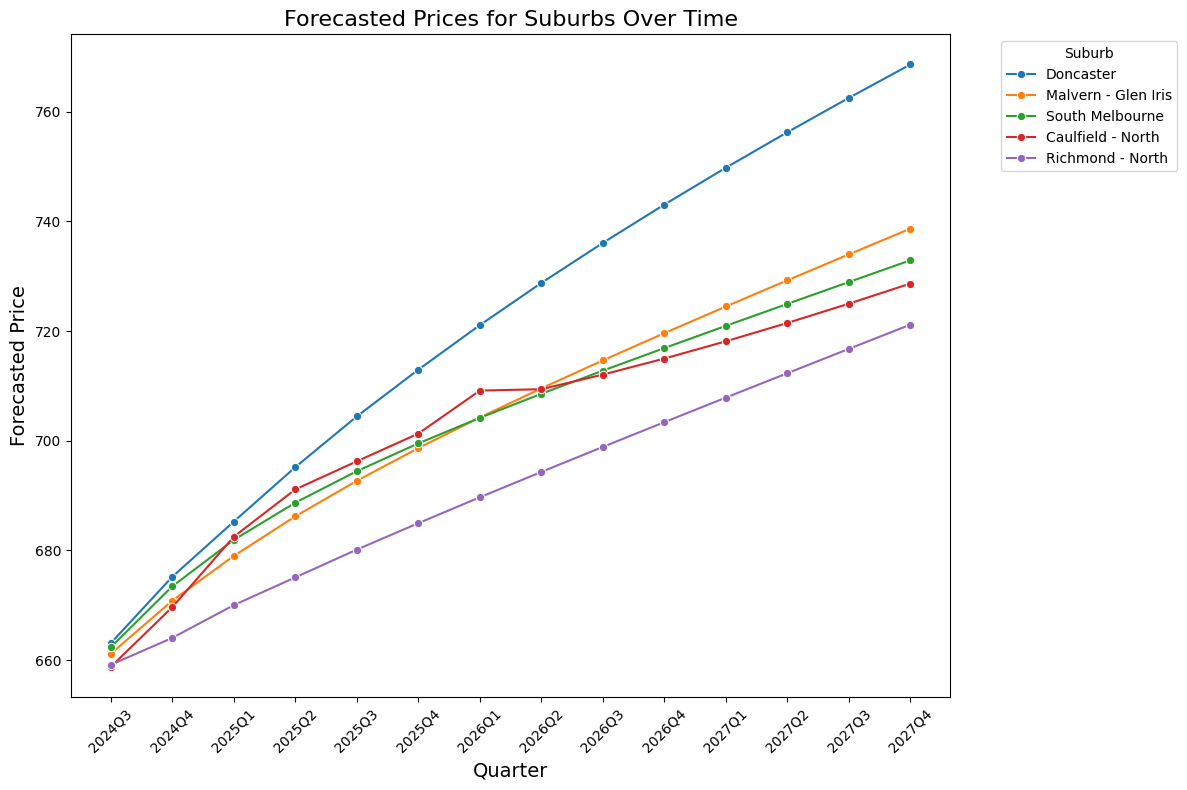

In [58]:
df_long = final_arima_df.sort_values("2027Q4", ascending=False).head().melt(id_vars="Suburb", var_name="Quarter", value_name="Forecasted Price")

# Ensure quarters are sorted correctly
df_long["Quarter"] = pd.Categorical(df_long["Quarter"], categories=final_arima_df.columns[1:], ordered=True)
df_long = df_long.sort_values(by="Quarter")

# Plotting with Seaborn
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_long, x="Quarter", y="Forecasted Price", hue="Suburb", marker="o")

# Customize the plot
plt.title("Forecasted Prices for Suburbs Over Time", fontsize=16)
plt.xlabel("Quarter", fontsize=14)
plt.ylabel("Forecasted Price", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="Suburb", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
final_arima_df.to_csv("../data/curated/future_predict_quarterly.csv")